<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula11a_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-06-05 23:29:08--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.14, 52.217.205.136, 52.217.232.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.7MB/s    in 0.3s    

2023-06-05 23:29:09 (39.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
  data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines)))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

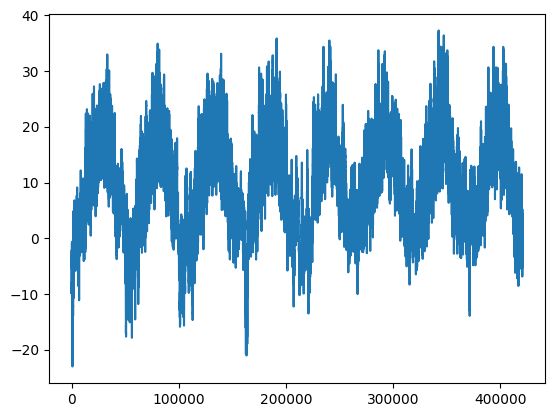

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

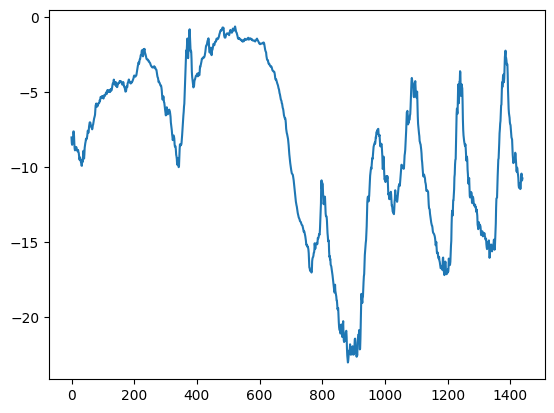

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
    shuffle = True,
)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[4, 5, 6] 7
[1, 2, 3] 4
[0, 1, 2] 3
[2, 3, 4] 5
[3, 4, 5] 6


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (256, 120, 14)
targets shape (256,)


# baseline

In [11]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


# densely conected

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 59ms/step - loss: 11.6517 - mae: 2.6435 - val_loss: 11.9775 - val_mae: 2.7416
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 8.5689 - mae: 2.3049 - val_loss: 10.2507 - val_mae: 2.5299
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.0115 - mae: 2.2278 - val_loss: 9.9985 - val_mae: 2.4906
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 7.6074 - mae: 2.1705 - val_loss: 10.1971 - val_mae: 2.5201
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 7.3021 - mae: 2.1262 - val_loss: 10.1321 - val_mae: 2.5130
Epoch 6/10
819/819 [==============================] - 62s 75ms/step - loss: 7.0668 - mae: 2.0929 - val_loss: 10.4645 - val_mae: 2.5623
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 6.8683 - mae: 2.0630 - val_loss: 10.5183 - val_mae: 2.5677
Epoch 8/10
819/819 [==============================] - 4

In [14]:
evaluation = model.evaluate(test_dataset)
evaluation

405/405 [==============================] - 15s 35ms/step - loss: 10.8531 - mae: 2.5874


[10.853050231933594, 2.5874249935150146]

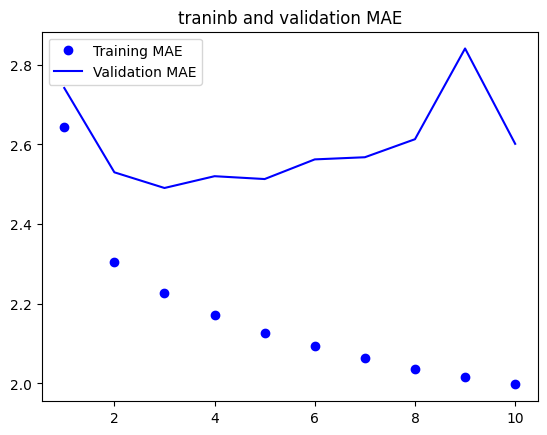

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("traninb and validation MAE")
plt.legend()
plt.show()

# 1D convolutional model

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 64ms/step - loss: 22.4991 - mae: 3.6875 - val_loss: 15.1850 - val_mae: 3.0745
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 14.9506 - mae: 3.0773 - val_loss: 14.2882 - val_mae: 2.9710
Epoch 3/10
819/819 [==============================] - 42s 50ms/step - loss: 13.6765 - mae: 2.9373 - val_loss: 15.8143 - val_mae: 3.1265
Epoch 4/10
819/819 [==============================] - 51s 61ms/step - loss: 12.9132 - mae: 2.8483 - val_loss: 14.7769 - val_mae: 3.0106
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 12.3804 - mae: 2.7892 - val_loss: 14.4049 - val_mae: 2.9730
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 11.9478 - mae: 2.7390 - val_loss: 14.3013 - val_mae: 2.9761
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 11.5556 - mae: 2.6937 - val_loss: 13.5584 - val_mae: 2.8864
Epoch 8/10
819/819 [============================

# LSTM

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 68ms/step - loss: 36.5313 - mae: 4.3863 - val_loss: 11.6566 - val_mae: 2.6129
Epoch 2/10
819/819 [==============================] - 53s 64ms/step - loss: 10.6620 - mae: 2.5366 - val_loss: 9.5075 - val_mae: 2.3918
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5557 - mae: 2.4037 - val_loss: 9.4230 - val_mae: 2.3685
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.1579 - mae: 2.3530 - val_loss: 9.5122 - val_mae: 2.3817
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 8.9010 - mae: 2.3202 - val_loss: 9.5623 - val_mae: 2.3823
Epoch 6/10
819/819 [==============================] - 58s 70ms/step - loss: 8.6584 - mae: 2.2895 - val_loss: 9.6681 - val_mae: 2.4013
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.4552 - mae: 2.2634 - val_loss: 9.5233 - val_mae: 2.3892
Epoch 8/10
819/819 [==============================] - 45s 5

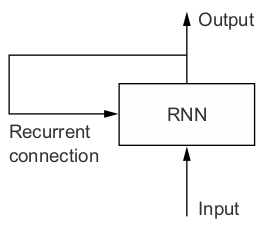

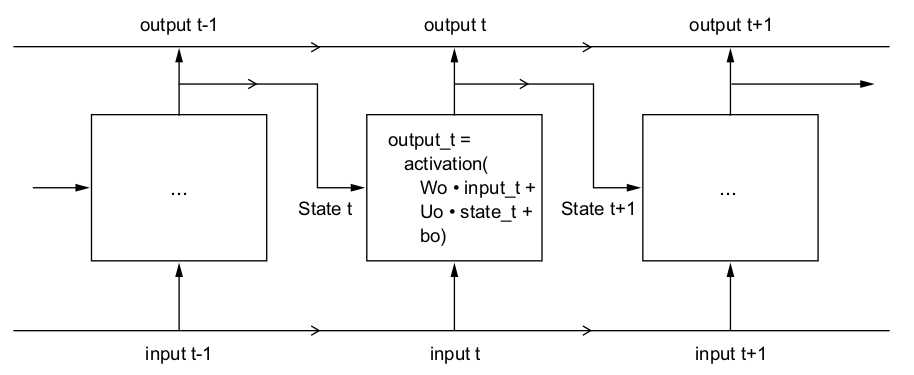



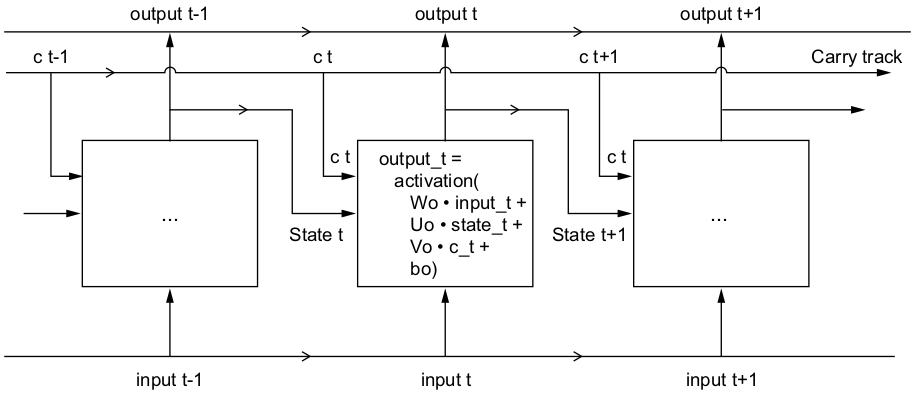

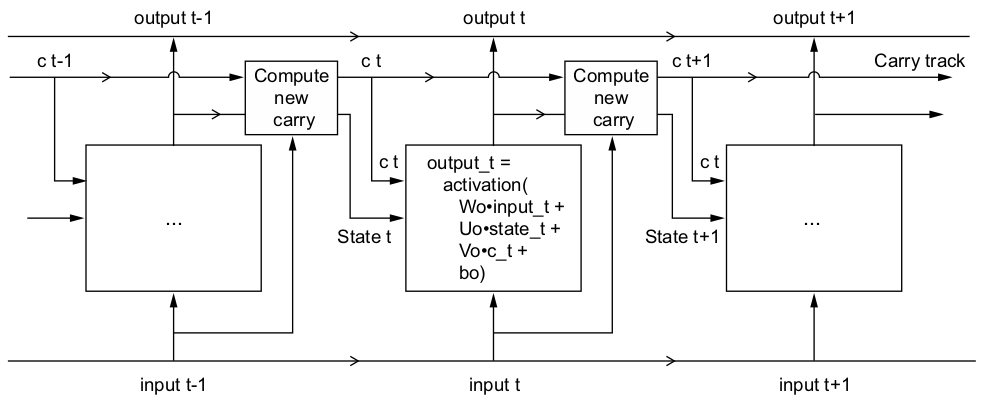

# dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

# bidirectional LSTM

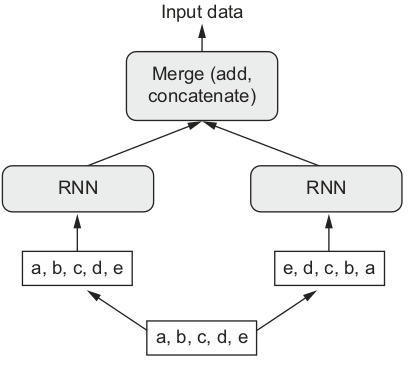

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_bidirectional.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 67ms/step - loss: 31.4936 - mae: 4.0296 - val_loss: 11.2873 - val_mae: 2.6095
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 9.9380 - mae: 2.4629 - val_loss: 9.5779 - val_mae: 2.3946
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 8.8166 - mae: 2.3093 - val_loss: 9.8015 - val_mae: 2.4218
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 8.2902 - mae: 2.2359 - val_loss: 9.6159 - val_mae: 2.4024
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 7.8537 - mae: 2.1768 - val_loss: 9.8991 - val_mae: 2.4378
Epoch 6/10
819/819 [==============================] - 54s 65ms/step - loss: 7.4975 - mae: 2.1281 - val_loss: 10.0297 - val_mae: 2.4564
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 7.1667 - mae: 2.0817 - val_loss: 10.0686 - val_mae: 2.4603
Epoch 8/10
819/819 [==============================] - 49s 